# Segment Anything Model (SAM) Workflow with FarmVibes.AI

This notebook demonstrates how to segment Sentinel-2 imagery, using a FarmVibes.AI workflow that leverages [Segment Anything Model](https://github.com/facebookresearch/segment-anything) (SAM). **We currently only support Unix-based systems (Linux and MacOS) for running this notebook.**

**Note:** if you are interested in an example that runs SAM outside of FarmVibes.AI cluster, refer to the `sam_exploration.ipynb` notebook.

The notebook is divided into the following sections:

1. **Environment setup**: this section provides instructions for setting up the micromamba environment for FarmVibes.AI and importing the necessary libraries for the notebook. We also download and export the ONNX files required to run SAM workflows to our cluster.

2. **Workflow setup**: we define a location and time range of interest for our analysis, and build our prompt with multiple points.

3. **Running the workflow**: this section discusses the parameters of the SAM workflow and demonstrates how to run it.

4. **Visualizing the results**: finally, we visualize the results of the workflow.

We run steps 3 and 4 for a few different parameter combinations to demonstrate the effect of the parameters on the results.


## Environment setup

Before running this notebook, make sure to set up a micromamba environment with all the required dependencies for FarmVibes.AI.



**If you already have imported the ONNX files to your cluster**, the standard environment provided in the [README file](../README.md) is sufficient, as most computation will be done within the cluster.

```bash
$ micromamba activate farmvibes-ai
```


### Importing SAM's ONNX models to the cluster

Before running SAM workflows in FarmVibes.AI, we need to add the model to our cluster. We provide a script that downloads the original weights from the [official repository](https://github.com/facebookresearch/segment-anything) and separately converts the image encoder and prompt encoder + mask decoder to ONNX format. The script also adds the ONNX models to our cluster, allowing them to be used in workflows.

**If you are importing the ONNX files to your cluster for the first time**, make sure the following environment is configured:

```bash
$ micromamba env create -f env_cpu.yaml
$ micromamba activate segment_anything_cpu
```

With the environment activated, execute the following command **in the repository root**:

```bash
$ python scripts/export_sam_models.py --models <model_types>
```

where `<model_types>` is a list of model types to be exported (`vit_b`, `vit_l`, `vit_h`). For example, to export all three ViT backbones, run:

```bash
$ python scripts/export_sam_models.py --models vit_b vit_l vit_h
```

In this notebook, we will export the `vit_b` model:

In [ ]:
! python ../../scripts/export_sam_models.py --models vit_b

### Imports

**If you already have imported the ONNX files to your cluster**, the standard environment provided in the [README file](../README.md) is sufficient, as most computation will be done within the cluster.

```bash
$ micromamba activate farmvibes-ai
```

Let's start the notebook by importing the necessary libraries:

In [1]:
import os
from datetime import datetime

from notebook_lib.utils import plot_rasters_prompts_masks
from shapely import geometry as shpg

from vibe_core.client import get_default_vibe_client
from vibe_core.data.core_types import DataVibe, ExternalReferenceList, gen_guid
from vibe_notebook.utils import create_geojson_file_from_point

### Storage Path

To feed the prompts to the workflow, we will create a GeoDataFrame and save it in the FarmVibes.AI cache directory. During setup, FarmVibes.AI stores the path to the cache directory in `~/.config/farmvibes-ai/storage` (or `{XDG_CONFIG_HOME}/farmvibes-ai/storage` if you had a `XDG_CONFIG_HOME` environment variable set).

Make sure the `storage_dir` variable below points to the same path as the one in the storage file.

In [2]:
config_dir = os.environ.get("XDG_CONFIG_HOME", os.path.expanduser("~/.config"))
storage_config_path = os.path.join(config_dir, "farmvibes-ai", "storage")
try:
    with open(storage_config_path) as f:
        storage_dir = f.read().strip()
    print(f"Cache directory set to '{storage_dir}' by reading '{storage_config_path}'")
except FileNotFoundError:
    print(
        f"Could not find FarmVibes.AI cache directory at '{storage_config_path}'! Please assign the correct value to `storage_dir`"
    )

Cache directory set to '/home/rpadilha/.cache/farmvibes-ai' by reading '/home/rpadilha/.config/farmvibes-ai/storage'


## Workflow setup

FarmVibes.AI has a few workflows related to SAM. The `ml/segment_anything/s2_prompt_segmentation` is the basic workflow that takes a Sentinel-2 raster, an input geometry of the Region of Interest (RoI), and an `ExternalReferenceList` pointing to a GeoDataFrame containing the points and/or bounding boxes used as prompts, their labels (`foreground` or `background`) and associated prompt ids (indicating the prompt to which a point belongs), and returns a CategoricalRaster with the segmentation results (one per prompt).

To facilitate its use, we also provide the `farm_ai/segmentation/segment_s2` workflow, which combines the `data_ingestion/sentinel2/preprocess_s2` workflow to download Sentinel-2 imagery and the `ml/segment_anything/s2_prompt_segmentation` workflow to run the segmentation. In addition to the `ExternalReferenceList` inputs for the prompts, this workflow expects a `DataVibe` with the geometry and a time range of interest.

Before inspecting how the workflow is defined, let's instantiate our client:


In [3]:
client = get_default_vibe_client()

The definition of the `farm_ai/segmentation/segment_s2` workflow can be inspected with:

In [4]:
client.document_workflow("farm_ai/segmentation/segment_s2")

Workflow: farm_ai/segmentation/segment_s2

Description:

Downloads Sentinel-2 imagery and runs Segment Anything Model (SAM) over them with points and/or 
    bounding boxes as prompts. The workflow retrieves the relevant Sentinel-2 products with the     
    Planetary Computer (PC) API, and splits the input rasters into chips of 1024x1024 pixels with an
    overlap defined by `spatial_overlap`. Chips intersecting with prompts are processed by SAM's    
    image encoder, followed by prompt encoder and mask decoder. Before running the workflow, make   
    sure the model has been imported into the cluster by running                                    
    `scripts/export_prompt_segmentation_models.py`. The script will download the desired model      
    weights from SAM repository, export the image encoder and mask decoder to ONNX format, and add  
    them to the cluster. For more information, refer to the [FarmVibes.AI                           
    troubleshooting](https://microsoft.github.io/farmvibes-ai/docfiles/markdown/TROUBLESHOOTING.html
    ) page in the documentation.

Sources:

- user_input (vibe_core.data.core_types.DataVibe): Time range and geometry of interest.

- prompts (List[vibe_core.data.core_types.ExternalReferenceList]): ExternalReferences to the    
    point and/or bounding box prompts. These are GeoJSON with coordinates, label                    
    (foreground/background) and prompt id (in case, the raster contains multiple entities that      
    should be segmented in a single workflow run).

Sinks:

- s2_raster (vibe_core.data.sentinel.Sentinel2Raster): Sentinel-2 rasters used as input for the 
    segmentation.

- segmentation_mask (vibe_core.data.rasters.CategoricalRaster): Output segmentation masks.

Parameters:

- model_type (default: vit_b): SAM's image encoder backbone architecture, among 'vit_h',        
    'vit_l', or 'vit_b'. Before running the workflow, make sure the desired model has been exported 
    to the cluster by running `scripts/export_sam_models.py`. For more information, refer to the    
    FarmVibes.AI troubleshooting page in the documentation.

- spatial_overlap (default: 0.5): Percentage of spatial overlap between chips in the range of   
    [0.0, 1.0).

- pc_key (default: ): Optional Planetary Computer API key.

Tasks:

- preprocess_s2: Downloads and preprocesses Sentinel-2 imagery that covers the input geometry   
    and time range.

- s2_segmentation: Runs Segment Anything Model (SAM) over Sentinel-2 rasters with points and/or 
    bounding boxes as prompts.

The workflow has three parameters:

- `model_type`: defines the backbone architecture for SAM's image encoder, among `vit_b`, `vit_l`, and `vit_h`. The default value is `vit_b`.
- `spatial_overlap`: the input raster is split into chips of size 1024x1024 pixels. This parameter defines the spatial overlap between chips in the segmentation process. The default value is 0.5, meaning that the chips will overlap by 50%.
- `pc_key`: an optional Planetary Computer API key to be used to download Sentinel-2 imagery.

Let's define a location and time range to download data from. In this example, we select a small region around a defined latitude/longitude and a time range of a few days.

In [5]:
geom = shpg.Point(-119.21896203939313, 46.44578909859286).buffer(0.07, cap_style=3)
time_range = (datetime(2020, 5, 1), datetime(2020, 5, 5))

roi_time_range = DataVibe(
    id=gen_guid(), time_range=time_range, geometry=shpg.mapping(geom), assets=[]
)

We will also define a prompt with multiple points. The prompt is defined as a GeoDataFrame with the following columns:
- `geometry`: the list of points and/or bounding boxes that define the prompts.
- `label`: the label of each point, either 1 (the entity of interest or `foreground`) or 0 (not part of the entity of interest, or `background`).
- `prompt_id`: the id of the prompt to which each point belongs. Each prompt is defined as a set of points with the same `prompt_id`. The resulting segmentation mask will have a number of channels equal to the number of unique `prompt_id` values.

In this initial example, we will define 3 prompts. The first prompt will consist on four points across a river, whereas the remaining two prompts will be single-point prompts on two crop fields. The `prompt_id` values will be 0, 1, and 2, respectively, to highlight these are three different entities to be segmented. For now, the `label` values will be 1 for all points as we will not have 'background' points. The Sentinel-2 image and the prompts can be seen in the [next section](#visualizing-the-results).

In [6]:
point_list = [
    # Prompt 0 - River points
    shpg.Point(-119.26547198690993, 46.451875370803414),
    shpg.Point(-119.26336098664864, 46.4655760422024),
    shpg.Point(-119.26312845986224, 46.43954823602075),
    shpg.Point(-119.2608366093817, 46.43542519065661),
    shpg.Point(-119.26424972761195, 46.414014420571874),
    shpg.Point(-119.26738020466517, 46.50954827923965),
    # Prompt 1 - Crop field point
    shpg.Point(-119.20314156716711, 46.450779271211765),
    # Prompt 2 - Another crop field point
    shpg.Point(-119.2075790583149, 46.43965317746578),
]
prompt_ids = [0, 0, 0, 0, 0, 0, 1, 2]  # grouping points with different ids
labels = [1, 1, 1, 1, 1, 1, 1, 1]  # all foreground

filepath, gdf, fid = create_geojson_file_from_point(point_list, labels, prompt_ids, storage_dir)
geom_collection = ExternalReferenceList(
    id=f"geo_{fid}", time_range=time_range, geometry=shpg.mapping(geom), assets=[], urls=[filepath]
)

/home/rpadilha/TerraVibes/y/envs/farmvibes-ai/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## Running the workflow

In [7]:
run = client.run(
    "farm_ai/segmentation/segment_s2",
    "SAM segmentation",
    input_data={"user_input": roi_time_range, "prompts": geom_collection},
)
run.monitor()

Output()

## Visualizing the results

The output of the segmentation is a mask with the same size as the input RoI, with each channels corresponding to a prompt. The values of the mask are 0 (background) or 1 (foreground). We can visualize the mask by plotting the mask for each prompt, as well as the foreground (green) and background (red) points used as prompts.

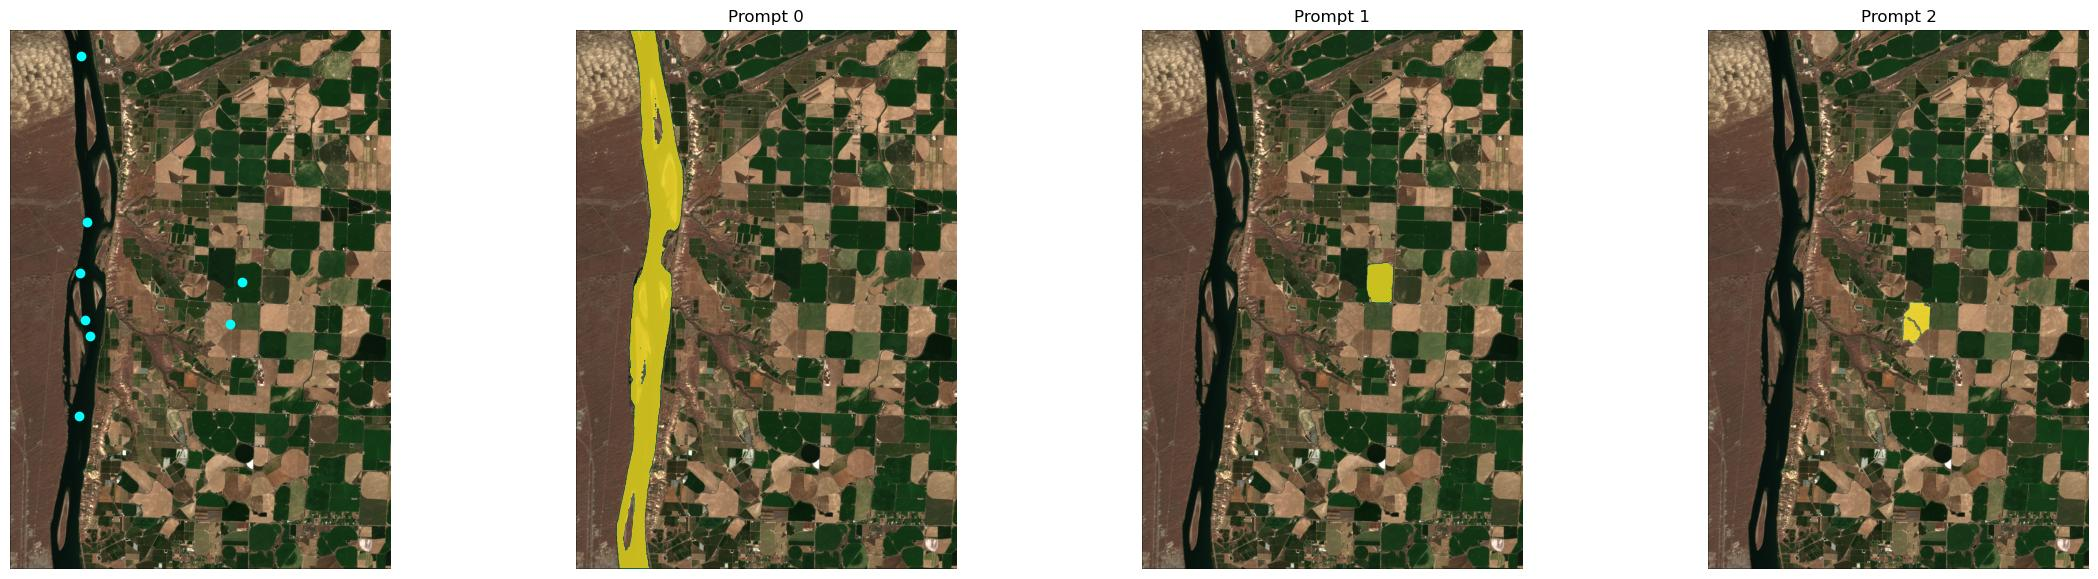

In [8]:
plot_rasters_prompts_masks(
    run.output["s2_raster"][0], run.output["segmentation_mask"][0], geom, gdf, labels
)

As we can see, the segmentation is not perfect, but it is able to identify the river and the crop fields. Even though the fields are well segmented, the model has more difficulty when segmenting the river. To refine that segmentation, we can add 'background' points to the prompt, which sinalizes to the model that the area around them is not part of the entity of interest. In doing so, we might be able to mask out the small islands in the river.

In [9]:
point_list = [
    # Initial prompt - Foregound river points
    shpg.Point(-119.26547198690993, 46.451875370803414),
    shpg.Point(-119.26336098664864, 46.4655760422024),
    shpg.Point(-119.26312845986224, 46.43954823602075),
    shpg.Point(-119.2608366093817, 46.43542519065661),
    shpg.Point(-119.26424972761195, 46.414014420571874),
    shpg.Point(-119.26738020466517, 46.50954827923965),
    # Background island points
    shpg.Point(-119.2629152042414, 46.48935759242608),
    shpg.Point(-119.2575570755061, 46.47705948718639),
    shpg.Point(-119.26655313644285, 46.44515072631643),
    shpg.Point(-119.25842992347287, 46.446605588183004),
    shpg.Point(-119.26701259696175, 46.43008409514595),
    shpg.Point(-119.27016443733498, 46.38451765944581),
]
prompt_ids = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # same prompt id
labels = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]  # foreground and background labels

filepath, gdf, fid = create_geojson_file_from_point(point_list, labels, prompt_ids, storage_dir)
geom_collection = ExternalReferenceList(
    id=f"geo_{fid}", time_range=time_range, geometry=shpg.mapping(geom), assets=[], urls=[filepath]
)

/home/rpadilha/TerraVibes/y/envs/farmvibes-ai/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


With those defined, we can now run the workflow once again:

In [10]:
run = client.run(
    "farm_ai/segmentation/segment_s2",
    "River segmentation with background points",
    input_data={"user_input": roi_time_range, "prompts": geom_collection},
)
run.monitor()

Output()

And visualize the results:

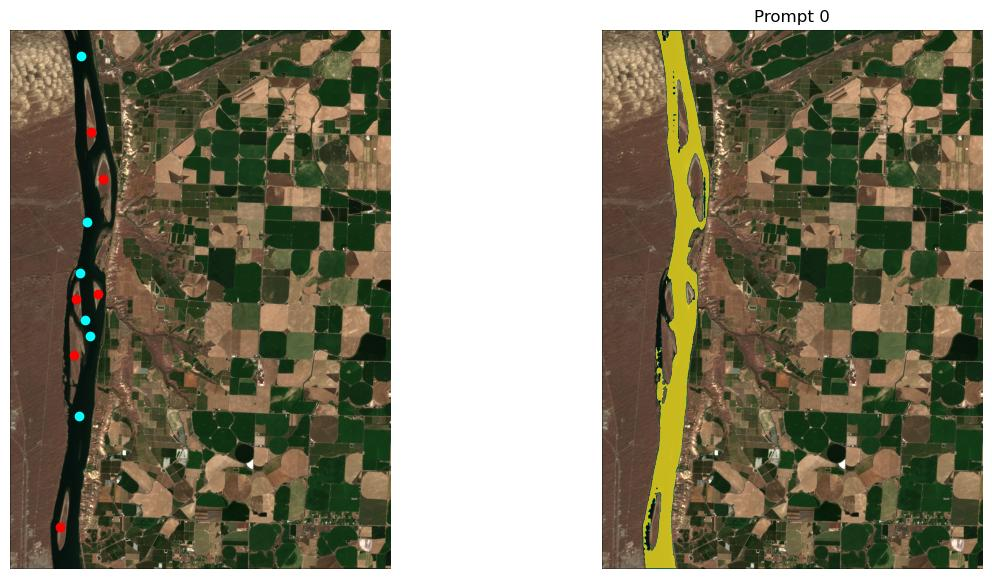

In [11]:
plot_rasters_prompts_masks(
    run.output["s2_raster"][0], run.output["segmentation_mask"][0], geom, gdf, labels
)

## Bounding Boxes as prompts

We can also combine a set of points with a bounding box to limit the segmentation to a specific region. When using bounding boxes, the following aspects should be considered:

- Only a single bounding box is supported per prompt group (i.e., all points with the same `prompt_id`).
- We recommend providing at least one foreground point within the bounding box. Even though the model supports segmentating rasters with only a bounding box, the results may be unreliable in some cases. 
- If the prompt contains a foreground point outside the provided bounding box, the workflow will adjust the bounding box to include all foreground points in that prompt group.
- Background points outside the bounding box are ignored.
- Regions outside the bounding box will be masked out in the final segmentation mask.

We define a bounding box as a `shapely.geometry.Polygon`. In this example, we will use the `shapely.geometry.box` function to create a bounding box around the river::

In [12]:
point_list = [
    # Bounding box
    shpg.box(-119.24966031524966, 46.40031374917289, -119.27706165804761, 46.4655760422024),
]
prompt_ids = [0]
labels = [1]

filepath, gdf, fid = create_geojson_file_from_point(point_list, labels, prompt_ids, storage_dir)
geom_collection = ExternalReferenceList(
    id=f"geo_{fid}", time_range=time_range, geometry=shpg.mapping(geom), assets=[], urls=[filepath]
)

# Running the workflow
run = client.run(
    "farm_ai/segmentation/segment_s2",
    "River segmentation with bbox",
    input_data={"user_input": roi_time_range, "prompts": geom_collection},
    parameters={"spatial_overlap": 0.25},
)
run.monitor()

Output()

Let's visualize the results:

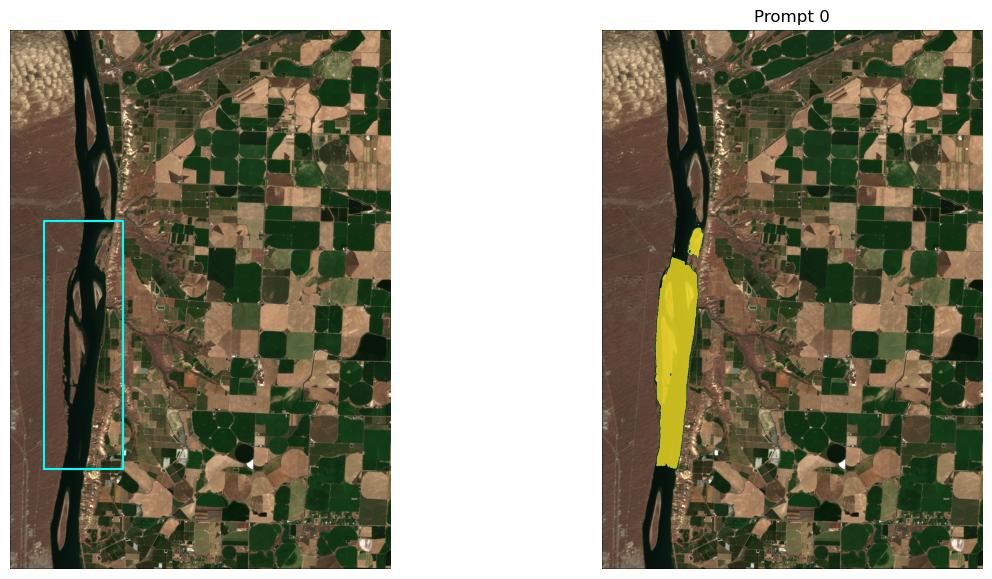

In [13]:
plot_rasters_prompts_masks(
    run.output["s2_raster"][0], run.output["segmentation_mask"][0], geom, gdf, labels
)

In this case, as we prompted the model solely with a bounding box, the segmentation covers more of the river area, including some of the islands in it. Let's add one foreground point within the waters to refine the segmentation:

In [14]:
point_list = [
    # Foregound river point
    shpg.Point(-119.2608366093817, 46.43542519065661),
    # Bounding box
    shpg.box(-119.24966031524966, 46.40031374917289, -119.27706165804761, 46.4655760422024),
]
prompt_ids = [0] * len(point_list)  # same prompt id
labels = [1] * len(point_list)  # foreground and background labels

filepath, gdf, fid = create_geojson_file_from_point(point_list, labels, prompt_ids, storage_dir)
geom_collection = ExternalReferenceList(
    id=f"geo_{fid}", time_range=time_range, geometry=shpg.mapping(geom), assets=[], urls=[filepath]
)

# Running the workflow
run = client.run(
    "farm_ai/segmentation/segment_s2",
    "River segmentation with bbox",
    input_data={"user_input": roi_time_range, "prompts": geom_collection},
    parameters={"spatial_overlap": 0.25},
)
run.monitor()

/home/rpadilha/TerraVibes/y/envs/farmvibes-ai/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Output()

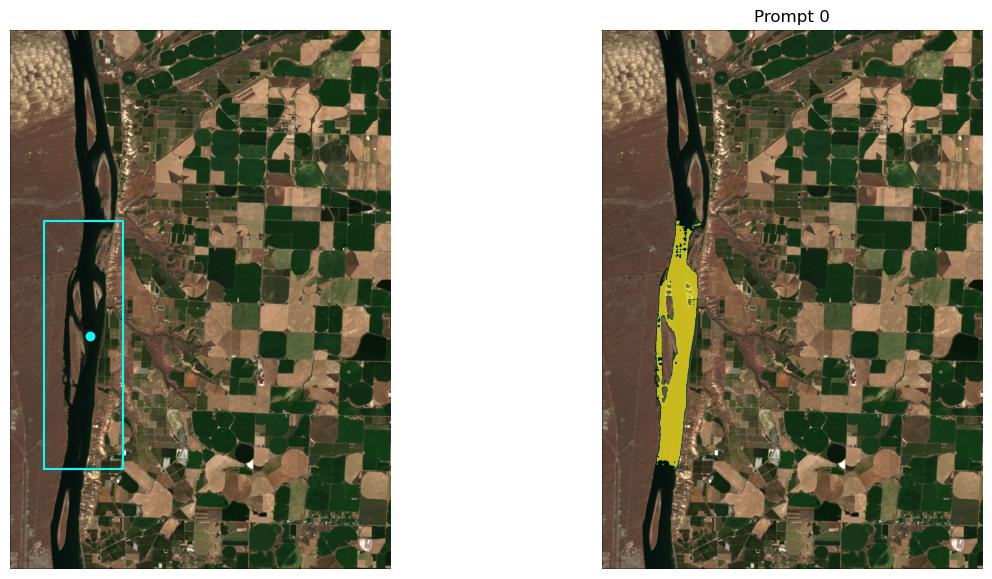

In [15]:
plot_rasters_prompts_masks(
    run.output["s2_raster"][0], run.output["segmentation_mask"][0], geom, gdf, labels
)

Some of the islands are masked out by the model, but the river is now better segmented. Adding more points would further improve the segmentation.